In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from random import random
from statsmodels.tsa.api import ExponentialSmoothing 

A company provides an entertainment platform for music, video, live stream, chat, etc. 
The company server system is divided into zones by geographic area. 
In order to meet the growing number of users, the company is interested in forecasting the total bandwidth of each server zone and the maximum number of users simultaneously accessing the server within the next month.

### I. Upload Dataset and Visualization

#### 1.1.Upload Data and Indexing with Time

In [4]:
df0 = pd.read_csv('train.csv')
df0.columns = df0.columns.str.capitalize()
df0.head()

,Update_time,Zone_code,Hour_id,Bandwidth_total,Max_user
0,2017-10-01,ZONE01,0,16096.710313,212415.0
1,2017-10-01,ZONE01,1,9374.207907,166362.0
2,2017-10-01,ZONE01,2,5606.225750,146370.0
3,2017-10-01,ZONE01,3,4155.654661,141270.0
4,2017-10-01,ZONE01,4,3253.978594,139689.0


In [5]:
# Checking missing value
df0.isnull().sum()

Update_time        0
Zone_code          0
Hour_id            0
Bandwidth_total    0
Max_user           0
dtype: int64

In [7]:
# Group columns Bandwidth_total and Max_user by Update_time and Zone_code
df = df0.copy()
df = pd.DataFrame(df.groupby(['Update_time','Zone_code'])['Bandwidth_total','Max_user'].sum())
df.reset_index(inplace= True)
df['Update_time'] = pd.to_datetime(df['Update_time'])
df['weekday'] = df['Update_time'].dt.weekday
df.set_index(df['Update_time'], inplace= True)
df = df.drop(columns = 'Update_time')
df.head()

,Zone_code,Bandwidth_total,Max_user,weekday
Update_time,,,,
2017-10-01,ZONE01,589698.902642,7151985.0,6
2017-10-02,ZONE01,396566.898750,6658611.0,0
2017-10-03,ZONE01,382938.701623,6619290.0,1
2017-10-04,ZONE01,385327.309006,6635865.0,2
2017-10-05,ZONE01,374036.167589,6504081.0,3


#### 1.2.Visualization data

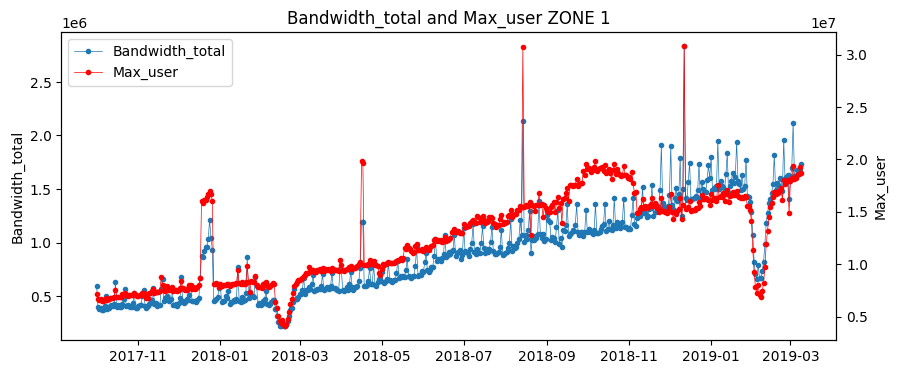

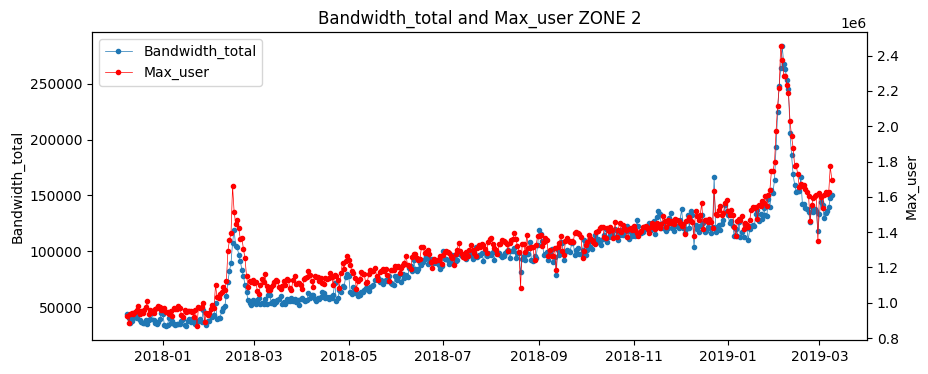

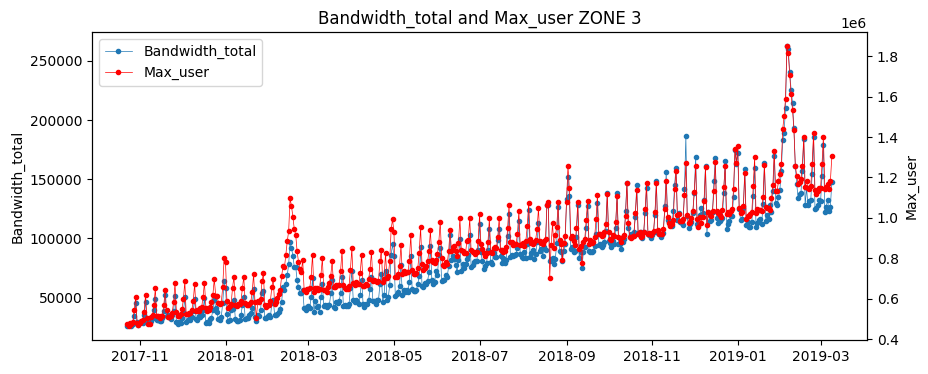

In [20]:
df1= df[(df['Zone_code'] == 'ZONE01')]
df2= df[(df['Zone_code'] == 'ZONE02')]
df3= df[(df['Zone_code'] == 'ZONE03')]

i = 1
for data in [df1,df2,df3]:
    y1 = data['Bandwidth_total']
    y2 = data['Max_user']
    fig, ax1 = plt.subplots(figsize = (10,4))
    ax2 = ax1.twinx()
    lns1= ax1.plot(y1, marker = '.',linestyle='-', linewidth=0.5, label='Bandwidth_total')
    lns2 = ax2.plot(y2,marker = '.',linestyle='-', linewidth=0.5, label='Max_user', color = 'r')
    ax1.set_ylabel('Bandwidth_total')
    ax2.set_ylabel('Max_user')
    ax1.set_title(f'Bandwidth_total and Max_user ZONE {i}')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    i += 1
    plt.show()

### II. Handle outliers of model

#### 2.1.Consider outliers of Bandwidth_total

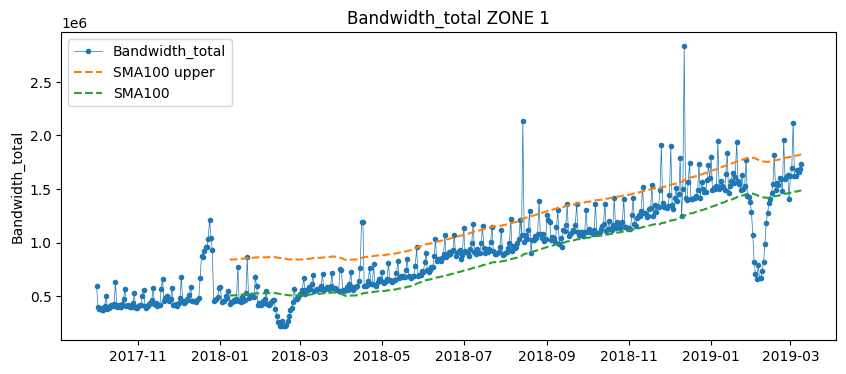

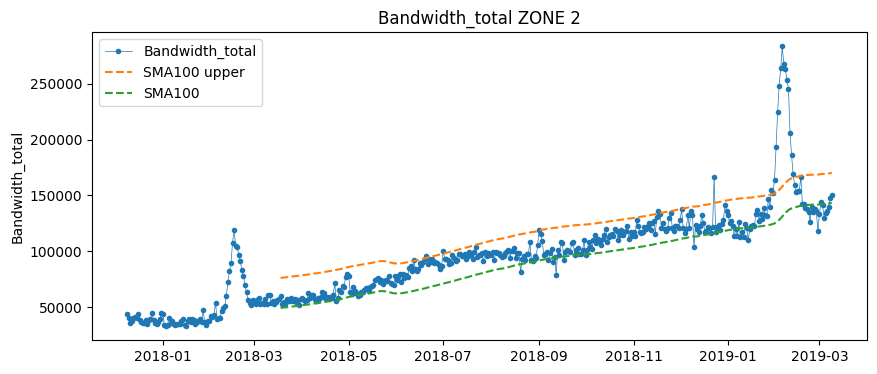

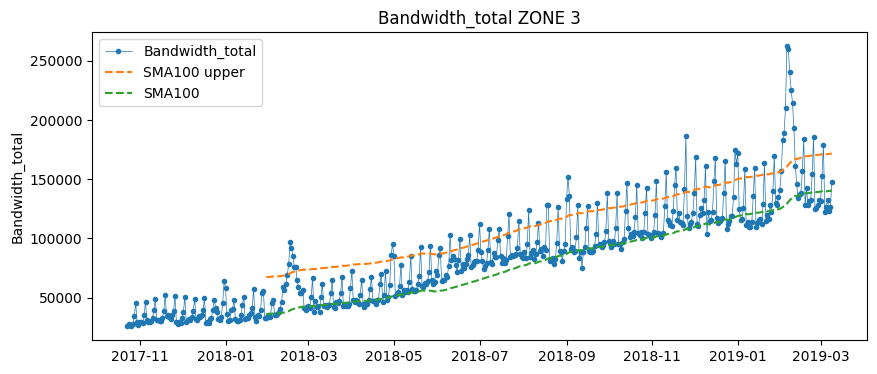

In [21]:
# Consider outliers of model in Bandwidth_total features:
i = 1
for data in [df1,df2,df3]:
    data['SMA_Bandwidth_total'] = data.iloc[:,1].rolling(window = 100).mean()
    data['SMA_upper_Bandwidth_total'] = data['SMA_Bandwidth_total'] + data['SMA_Bandwidth_total'].std()
    # data['SMA_lower_Bandwidth_total'] = data['SMA_Bandwidth_total'] - 0.4*data['SMA_Bandwidth_total'].std()
    y1 = data['Bandwidth_total']
    y2 = data['Max_user']
    fig, ax1 = plt.subplots(figsize = (10,4))
    lns1= ax1.plot(y1,marker='.', linestyle='-', linewidth=0.5, label='Bandwidth_total')
    lns3 = ax1.plot(data['SMA_upper_Bandwidth_total'],linestyle = '--', label = 'SMA100 upper')
    # lns4 = ax1.plot(data['SMA_lower_Bandwidth_total'],linestyle = '--', label = 'SMA100 lower')
    lns5 = ax1.plot(data['SMA_Bandwidth_total'], linestyle = '--', label = 'SMA100')
    ax1.set_ylabel('Bandwidth_total')
    ax1.set_title(f'Bandwidth_total ZONE {i}')
    lns = lns1+lns3+lns5
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    i += 1
    plt.show()

As the data has outliers at holiday (especially Tet holiday in February 2018 and 2019), we replace outlier by SMA_support line, which is contribute of SMA90 and SMA7, SMA50 (Each SMA has weight).

In [8]:
# Create dataset after handling outliers
df_new = pd.DataFrame()
i = 0
for zone in ['ZONE01','ZONE02','ZONE03']:   
    for hour_id in range(0,24):
        data = df0[(df0['Zone_code'] == zone)&(df0['Hour_id'] == hour_id)]
        data['SMA_Bandwidth_total'] = data.iloc[:,3].rolling(window = 100).mean()
        data['SMA_upper_Bandwidth_total'] = data['SMA_Bandwidth_total'] + data['SMA_Bandwidth_total'].std()
        data['SMA_support_lower'] = -0.2*data.iloc[:,3].rolling(window = 7).mean() + 0.9*data.iloc[:,3].rolling(window = 100).mean()+0.3*data.iloc[:,3].rolling(window = 50).mean()
        data['SMA_support_upper'] = 0.1*data.iloc[:,3].rolling(window = 7).mean() + 0.65*data.iloc[:,3].rolling(window = 100).mean()+0.25*data.iloc[:,3].rolling(window = 50).mean()
        data['Bandwidth_total'] = np.where(data['Bandwidth_total'] > data['SMA_upper_Bandwidth_total'], data['SMA_support_upper'], data['Bandwidth_total'])
        data['Bandwidth_total'] = np.where(data['Bandwidth_total'] < data['SMA_Bandwidth_total'], data['SMA_support_lower'], data['Bandwidth_total'])
        data['SMA_Max_user'] = data.iloc[:,4].rolling(window = 100).mean()
        data['SMA_upper_Max_user'] = data['SMA_Max_user'] + data['SMA_Max_user'].std()
        data['SMA_support_lower_Max_user'] = -0.2*data.iloc[:,4].rolling(window = 7).mean() + 0.9*data.iloc[:,4].rolling(window = 100).mean()+0.3*data.iloc[:,4].rolling(window = 50).mean()
        data['SMA_support_upper_Max_user'] = 0.1*data.iloc[:,4].rolling(window = 7).mean() + 0.65*data.iloc[:,4].rolling(window = 100).mean()+0.25*data.iloc[:,4].rolling(window = 50).mean()
        data['Max_user'] = np.where(data['Max_user'] > data['SMA_upper_Max_user'], data['SMA_support_upper_Max_user'], data['Max_user'])
        data['Max_user'] = np.where(data['Max_user'] < data['SMA_Max_user'], data['SMA_support_lower_Max_user'], data['Max_user'])
        df_new = pd.concat([df_new, data], axis = 0)    
    i += 1
df_new.sort_index(inplace = True)
df_new.head()

,Update_time,Zone_code,Hour_id,Bandwidth_total,Max_user,SMA_Bandwidth_total,SMA_upper_Bandwidth_total,SMA_support_lower,SMA_support_upper,SMA_Max_user,SMA_upper_Max_user,SMA_support_lower_Max_user,SMA_support_upper_Max_user
0,2017-10-01,ZONE01,0,16096.710313,212415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-01,ZONE01,1,9374.207907,166362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,ZONE01,2,5606.225750,146370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,ZONE01,3,4155.654661,141270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,ZONE01,4,3253.978594,139689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


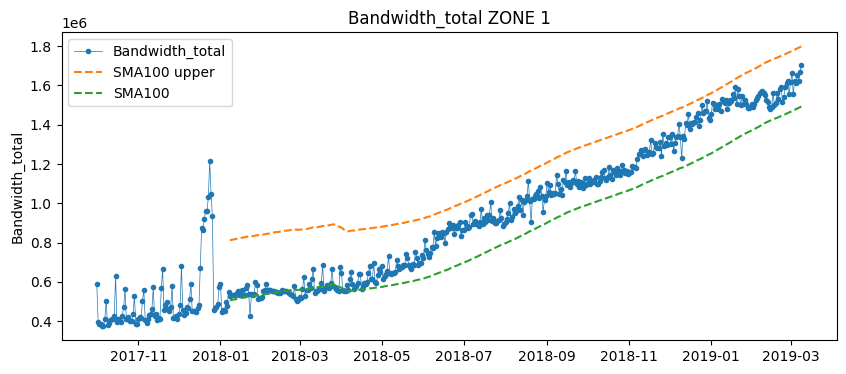

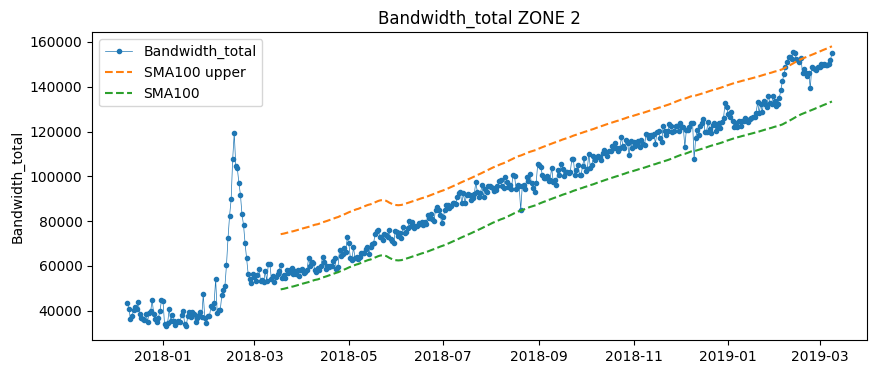

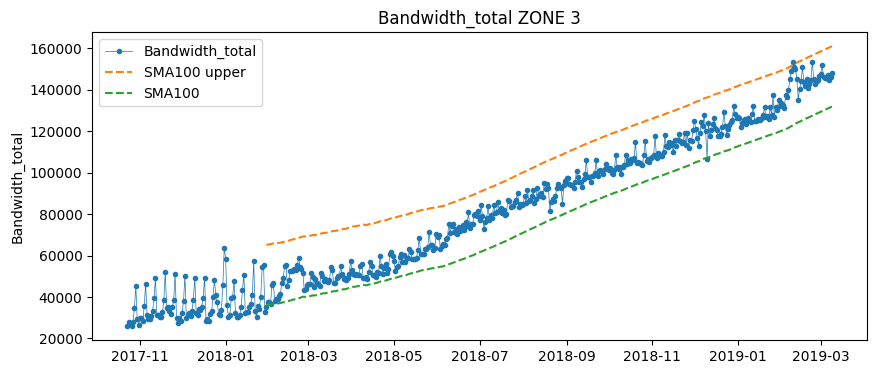

In [23]:
# Bandwidth_total feature after replace outliers
df1_new = pd.DataFrame(df_new[df_new['Zone_code'] == 'ZONE01'].groupby(['Update_time','Zone_code'])['Bandwidth_total','Max_user'].sum())
df2_new = pd.DataFrame(df_new[df_new['Zone_code'] == 'ZONE02'].groupby(['Update_time','Zone_code'])['Bandwidth_total','Max_user'].sum())
df3_new = pd.DataFrame(df_new[df_new['Zone_code'] == 'ZONE03'].groupby(['Update_time','Zone_code'])['Bandwidth_total','Max_user'].sum())
i = 0
for data in [df1_new, df2_new, df3_new]:
    data.reset_index(inplace = True)
    data['Update_time'] = pd.to_datetime(data['Update_time'])
    data.set_index(data['Update_time'], inplace = True)
    data.drop(columns = 'Update_time', inplace = True)
    data['SMA_Bandwidth_total'] = data.iloc[:,1].rolling(window = 100).mean()
    data['SMA_upper_Bandwidth_total'] = data['SMA_Bandwidth_total'] + data['SMA_Bandwidth_total'].std()
    y1 = data['Bandwidth_total']
    fig, ax1 = plt.subplots(figsize = (10,4))
    lns1= ax1.plot(y1,marker='.', linestyle='-', linewidth=0.5, label='Bandwidth_total')
    lns3 = ax1.plot(data['SMA_upper_Bandwidth_total'],linestyle = '--', label = 'SMA100 upper')
    # lns4 = ax1.plot(data['SMA_lower_Bandwidth_total'],linestyle = '--', label = 'SMA100 lower')
    lns5 = ax1.plot(data['SMA_Bandwidth_total'], linestyle = '--', label = 'SMA100')
    ax1.set_ylabel('Bandwidth_total')
    ax1.set_title(f'Bandwidth_total ZONE {i+1}')
    lns = lns1+lns3+lns5
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    i += 1
    plt.show()

#### 2.2.Consider outliers of Max_user features

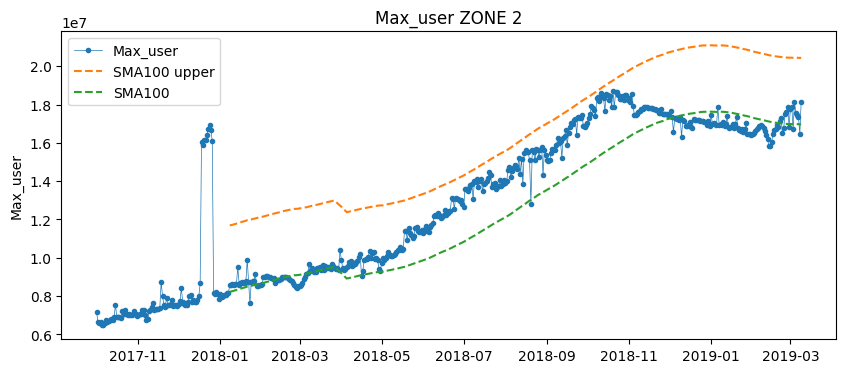

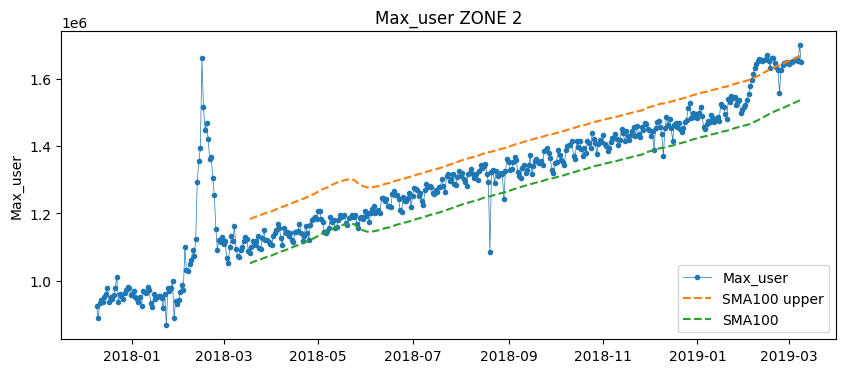

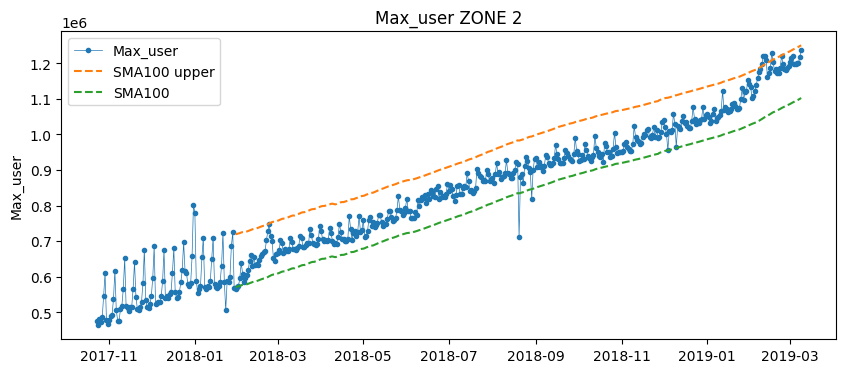

In [26]:
# Replace outliers of model in Bandwidth_total features:
i = 1
for data in [df1_new, df2_new, df3_new]:
    data.reset_index(inplace = True)
    data['Update_time'] = pd.to_datetime(data['Update_time'])
    data.set_index(data['Update_time'], inplace = True)
    data.drop(columns = 'Update_time', inplace = True)
    data['SMA_Max_user'] = data.iloc[:,2].rolling(window = 100).mean()
    data['SMA_upper_Max_user'] = data['SMA_Max_user'] + data['SMA_Max_user'].std()
    y1 = data['Max_user']
    fig, ax1 = plt.subplots(figsize = (10,4))
    lns1= ax1.plot(y1,marker='.', linestyle='-', linewidth=0.5, label='Max_user')
    lns3 = ax1.plot(data['SMA_upper_Max_user'],linestyle = '--', label = 'SMA100 upper')
    lns5 = ax1.plot(data['SMA_Max_user'], linestyle = '--', label = 'SMA100')
    ax1.set_ylabel('Max_user')
    ax1.set_title(f'Max_user ZONE {i+1}')
    lns = lns1+lns3+lns5
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

### III.Decomposing Datasset and Checking stationarity

#### 3.1.Decomposing Dataset

In [28]:
df_new['Update_time'] = pd.to_datetime(df_new['Update_time'])
df_new.set_index(df_new['Update_time'], inplace = True)
df_new.drop(columns = 'Update_time', inplace = True)
df_new.sort_index(inplace= True)
df_new.head()

,Zone_code,Hour_id,Bandwidth_total,Max_user,SMA_Bandwidth_total,SMA_upper_Bandwidth_total,SMA_support_lower,SMA_support_upper,SMA_Max_user,SMA_upper_Max_user,SMA_support_lower_Max_user,SMA_support_upper_Max_user
Update_time,,,,,,,,,,,,
2017-10-01,ZONE01,0,16096.710313,212415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,1,9374.207907,166362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,2,5606.225750,146370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,3,4155.654661,141270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,4,3253.978594,139689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


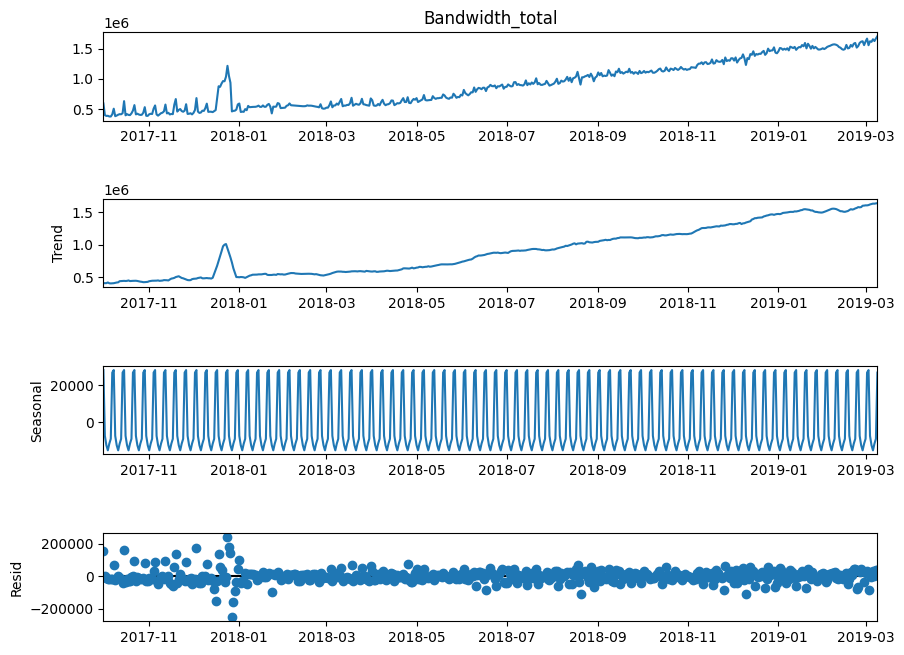

In [29]:
import statsmodels.api as sm

def seasonal_decompose(y, period):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', period = period)
    fig = decomposition.plot()
    fig.set_size_inches(10,7)
    plt.show()
seasonal_decompose(df1_new['Bandwidth_total'], 7)
# Dataset has both seasonality by week and trend

#### 3.2.Augmented Dickey-Fuller Test


In [30]:
# stationarity in Time series by Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [31]:
ADF_test(df1_new['Bandwidth_total'],'raw data')
ADF_test(df2_new['Bandwidth_total'],'raw data')
ADF_test(df3_new['Bandwidth_total'],'raw data')
# As the dataset is not stationary, we can't use moving average and S ARIMA

 > Is the raw data stationary ?
Test statistic = 0.589
P-value = 0.987
Critical values :
	1%: -3.4432372923913124 - The data is not stationary with 99% confidence
	5%: -2.86722383510113 - The data is not stationary with 95% confidence
	10%: -2.5697972702806613 - The data is not stationary with 90% confidence
 > Is the raw data stationary ?
Test statistic = -0.479
P-value = 0.896
Critical values :
	1%: -3.4451642100030084 - The data is not stationary with 99% confidence
	5%: -2.8680716196949327 - The data is not stationary with 95% confidence
	10%: -2.5702491139112085 - The data is not stationary with 90% confidence
 > Is the raw data stationary ?
Test statistic = 1.296
P-value = 0.997
Critical values :
	1%: -3.4438213751870337 - The data is not stationary with 99% confidence
	5%: -2.867480869596464 - The data is not stationary with 95% confidence
	10%: -2.5699342544006987 - The data is not stationary with 90% confidence


In conclusion, we use Holt Winters' seasonal method (As dataset is seasonal, trendy and not stationary)

### IV.Build Model and Tuning

#### 4.1.Train test split

In [32]:
from IPython.display import Image
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.model_selection import RandomizedSearchCV

In [33]:
# sMAPE function
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(A - F) / (np.abs(A) + np.abs(F)))

In [34]:
test = {}
train_tuning = {}
val_tuning = {}
test_full = pd.DataFrame()
i = 0
for data in [df1_new, df2_new, df3_new]:
    test[i] = data['Bandwidth_total'].tail(90)
    train_tuning[i] = data['Bandwidth_total'].head(len(data) - 180)
    val_tuning[i] = data['Bandwidth_total'].head(len(data) - 90).tail(90)
    test_full = pd.concat([test_full,test[i]], axis = 0)
    i += 1

#### 4.2.Build baseline for model by Holt model

As dataset doesn't have benchmark, I build baseline for model by tuning Holt model and evaluation by mean squared error

In [61]:
# Tuning Holt model
mse_val_set = [1089554207.1361594, 5833507.137665188, 10160778.132097969]
alpha_set = [0.025438738426862798, 0.07527974937231584, 0.09044852486293378]
beta_set = [0.1489176404029006, 0.17302285263391204, 0.06474250378026701]
forecast = pd.DataFrame()
for i in range(0,3):
    for iteration in range(0,1000):
        alpha = np.random.uniform(0,0.2)
        beta = np.random.uniform(0,0.4)
        fit_Holt = Holt(train_tuning[i],
                initialization_method="estimated").fit(smoothing_level = alpha,
                                                        smoothing_trend = beta)

        if mse_val_set[i] > mean_squared_error(val_tuning[i], fit_Holt.forecast(len(val_tuning[i]))):
            mse_val_set[i] = mean_squared_error(val_tuning[i], fit_Holt.forecast(len(val_tuning[i])))
            alpha_set[i] = alpha
            beta_set[i] = beta

for i in range(0,3):
    fit_Holt = Holt(train_tuning[i],
                initialization_method="estimated").fit(smoothing_level = alpha_set[i],
                                                        smoothing_trend = beta_set[i])
    forecast = pd.concat([forecast,pd.DataFrame(fit_Holt.forecast(180)['2018-12-10':])], axis = 0)

print('sMAPE for model', smape(test_full, forecast))
print('mse for 3 zone:',mse_val_set)
# After tuning, we have baseline for test set is smape = 3.57

sMAPE for model 0    3.523129
dtype: float64
mse for 3 zone: [1089554207.1361594, 5829982.564376142, 10160778.132097969]


#### 4.3.Tuning triple exponential smoothing

In [51]:
# Tuning triple exponential smoothing
mse_val_set_new = [1063045521.1650237, 5330943.199818842, 5604490.70078373]
alpha_set_new = [0.6755104711936868, 0.05850899534036513, 0.07902146048379088]
beta_set_new = [0.01672131473791727, 0.2173260000706536, 0.07028678414158895]
gamma_set_new = [0.10505823002406445, 0.08094527215987013, 0.14532210920607758]
phi_set_new = [0.2129820484325603, 0.3898457698198957, 0.49070253756376264]

for i in range(0,3):
    for iteration in range(0,1000):
        alpha = random()
        beta = random()
        gamma = random()
        phi = random()
        expo = ExponentialSmoothing( train_tuning[i],
                                initialization_method="estimated",
                                trend = 'add',
                                seasonal = 'mul').fit( smoothing_level = alpha,
                                                        smoothing_slope = beta,
                                                        smoothing_seasonal = gamma, 
                                                        damping_slope = phi )
        if mse_val_set_new[i] > mean_squared_error(val_tuning[i], expo.forecast(len(val_tuning[i]))):
            mse_val_set_new[i] = mean_squared_error(val_tuning[i], expo.forecast(len(val_tuning[i])))
            alpha_set_new[i] = alpha
            beta_set_new[i] = beta
            gamma_set_new[i] = gamma
            phi_set_new[i] = phi

In [64]:
i = 0
for zone in ['ZONE01','ZONE02','ZONE03']:
    print(f'Delta mse {zone}:', mse_val_set_new[i] - mse_val_set[i])
    i += 1
# As the Triple exponential smoothing mse set is lower than mse set of Holt model --> We use Triple exponential smoothing to forecast model

Delta mse ZONE01: -26508685.971135736
Delta mse ZONE02: -499039.36455729976
Delta mse ZONE03: -4556287.431314239


In [65]:
# Calculate smape for test set
forecast_new = pd.DataFrame()
for i in range(0,3):    
    expo = ExponentialSmoothing( train_tuning[i],
                                initialization_method="estimated",
                                trend = 'add',
                                seasonal = 'mul').fit( smoothing_level = alpha_set_new[i],
                                                        smoothing_slope = beta_set_new[i],
                                                        smoothing_seasonal = gamma_set_new[i], 
                                                        damping_slope = phi_set_new[i] )
    forecast_new = pd.concat([forecast_new,pd.DataFrame(expo.forecast(180)['2018-12-10':])], axis = 0)
    
smape(test_full, forecast_new)

0    3.885835
dtype: float64

#### 4.4.Evaluation for test set with Hour_id

In [46]:
df_new.head()

,Zone_code,Hour_id,Bandwidth_total,Max_user,SMA_Bandwidth_total,SMA_upper_Bandwidth_total,SMA_support_lower,SMA_support_upper,SMA_Max_user,SMA_upper_Max_user,SMA_support_lower_Max_user,SMA_support_upper_Max_user
Update_time,,,,,,,,,,,,
2017-10-01,ZONE01,0,16096.710313,212415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,1,9374.207907,166362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,2,5606.225750,146370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,3,4155.654661,141270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,ZONE01,4,3253.978594,139689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Evaluation with hour_id
df_test = pd.DataFrame()
i = 0
for zone in ['ZONE01','ZONE02','ZONE03']:
    expo = ExponentialSmoothing( train_tuning[i],
                                initialization_method="estimated",
                                trend = 'add',
                                seasonal = 'mul').fit( smoothing_level = alpha_set_new[i],
                                                        smoothing_slope = beta_set_new[i],
                                                        smoothing_seasonal = gamma_set_new[i], 
                                                        damping_slope = phi_set_new[i])
    data_expo = pd.concat([pd.DataFrame(expo.fittedvalues), pd.DataFrame(expo.forecast(180))], axis = 0).rename(columns = {0:'forecast'})
    for hour_id in range(0,24):
        data = df_new[(df_new['Hour_id'] == hour_id)&(df_new['Zone_code'] == zone)]
        data = pd.merge(data, data_expo, left_index=True, right_index=True)
        data['forecast'] = data['forecast']*(data['Bandwidth_total'][:'2018-12-09'].mean()/data_expo['forecast'][:'2018-12-09'].mean())
        df_test = pd.concat([df_test, data], axis = 0)    
    i += 1


In [60]:
df_test.sort_index(inplace = True)
smape(df_test['Bandwidth_total']['2018-12-10':], df_test['forecast']['2018-12-10':])

6.541692470023148